In [16]:
import numpy as np
import scipy
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa, librosa.display
plt.rcParams['figure.figsize'] = (14, 5)

# Energy and RMSE

Amplitudes vary with time and we may wish to know the mean value of such amplitudes over some particular time interval. When we do this we say we are measuring the *Energy* (or strength) of the signal.

Two common measures for the Energy are just the 'raw' energy, or the root mean squared energy, or RMSE.

Commonly, like many feature extraction processes in music, we wish to know the energy not for the *entire* signal, but for small segments of the signal, in order to capture the feature value *at a particular point in time*. To get the total energy, we sum over the squared values of all time points in a given window.

With RMSE, we have an averaging, where we account for the number of values being summed by including a $\frac{1}{N}$ normalization factor prior to taking the square root. (I.e., we calculate the mean of the squared values).

The **energy** of a discrete time signal corresponds to the *total* magntiude of the signal. This roughly corresponds to how loud a signal is. The energy in a signal is defined as

$$ \sum_n \left| x(n) \right|^2 $$

The **root-mean-square energy (RMSE)** in a signal is defined as

$$ \sqrt{ \frac{1}{N} \sum_n \left| x(n) \right|^2 } $$

Notice that we could also calculate the energy after we have transformed to spectral energy. That is, the energy of a given time frame must be spread in some way across the frequency band (this is what we are measuring when we are measuring the magnitude spectrum). As such, if we simply summed over all the bands, we would know the total magnitude for that time frame. 


(Thus, if you are *already* calculating other spectral features via a STFT procedure, you may wish to compute the energy or RMSE that way. However, for today, we will calculate energy directly from the discrete time signal.

Let's load a signal:

In [2]:
#x, sr = librosa.load('../uploaded_files/CongaGroove-mono.wav')
(fs, x) = read('../uploaded_files/CongaGroove-mono.wav')


In [3]:
fs 

44100

In [4]:
x.shape

(192425,)

In [5]:
#make duration array
dur = x.size/fs
dur = np.arange(0, dur, 1/fs)
#normalize amplitude
xnorm = x/np.abs(x.max())

Listen to the signal:

In [6]:
Audio(x, rate=fs)

Plot the signal:

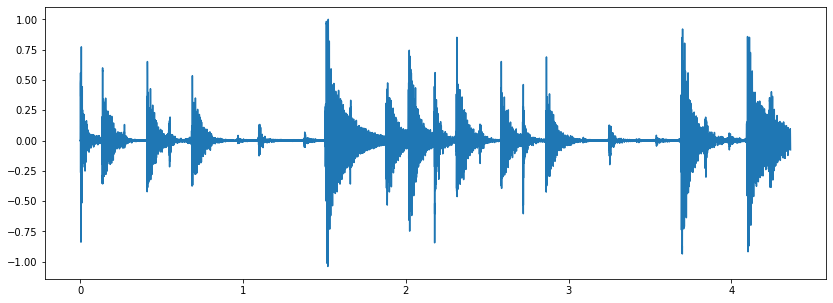

In [7]:
plt.plot(dur, xnorm)

Let's compute both Energy and RMSE for sliding windows of 1024 samples. 

Notice that we do not have to choose a power of 2 anymore. However, when calculating multiple features (including spectral ones, where you *will* use power of 2) it is wise to examine the same slice (or collection) of samples.

In [8]:
hop_length = 512 # 50% overlap
frame_length = 1024

In [9]:
energy = np.array([
    sum(abs(xnorm[i:i+frame_length]**2))
    for i in range(0, len(xnorm), hop_length)
])

In [10]:
energy.shape

(376,)

In [11]:
energy[0]

71.35002392164817

Compute the RMS using [`librosa.feature.rms`](https://librosa.org/doc/latest/generated/librosa.feature.rms.html#librosa.feature.rms):

In [12]:
rmse = librosa.feature.rms(xnorm, frame_length=frame_length, hop_length=hop_length, center=True)

In [13]:
rmse.shape

(1, 376)

Plot both the energy and RMSE along with the waveform:

In [14]:
frames = range(len(energy))
t = librosa.frames_to_time(frames, sr=fs, hop_length=hop_length)

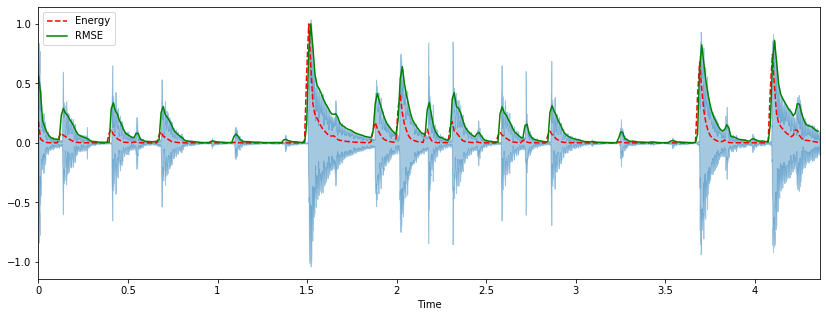

In [20]:
librosa.display.waveplot(xnorm, sr=fs, alpha=0.4)
plt.plot(t, energy/energy.max(), 'r--')       # normalized for visualization
plt.plot(t, rmse[0]/rmse[0].max(), color='g') # normalized for visualization
plt.legend(('Energy', 'RMSE'))

Notice that what we have done with the RMSE is plot the envelope of the signal!

## Some Definitions

**Attack** : sharp increase of energy

**Transient** : a short duration with high amplitude
within which signal evolves quickly

**Onset** : single instant marking the beginning of
transient. (Onsets frequently occur on beats.)

We have primarily until now been looking at *pitch-related* analysis tasks. Let us know consider *rhythm-related* analysis tasks. Here are a few:

* Onset detection
* Beat detection / beat tracking
* Tempo estimation

### Onset detection with Energy

One approach to onset detection is via the following procedure:

* Compute Energy (or RMSE) (optional: convert to log scale)
* Compute Derivative (differentiation) 
$\Delta E(n) = E(n+1) - E(n) $ 
* Perform half wave rectification (above or equal to zero; only energy increases are relevant for note onsets).
* Use a thresholding procedure where energy above some cutoff equals "1" (on) to identify onsets.


Notes: 
* log energy often better than linear energy
* Works best on tracks with percussion (true really of all onset detection methods!)

### Onset detection with Spectrum

An alternative approach uses spectral flux. Recall that spectral flux attempts to capture fast changing properties of the spectral content of the signal. Thus transients are well-captured with spectral flux.

* Compute STFT (optional: convert to log scale)
* Calculate spectral flux*
* Use thresholding procedure same as above.

Notes:

* less efficient & more complicated calculations (must sum over all frequency bins & use FFT)
* in some cases you may intentionally want to *only* sum over certain frequency bands (e.g., noise-like transient power will show up well above 1-2kHz)
* works slightly better for less percussive tracks with soft transients (e.g., legato notes, woodwinds, etc.)

### Tempo Estimation

How to estimate the tempo of a clip of music? We assume that onsets occur most frequently on beats, and beats are articulated more strongly and more frequently than off-beats, and should be approximately evenly spaced in time. (We also assume that the tempo is not changing for the purpose of this class!!)

Given this assumption, we need to examine the regularity or *periodicity* of the onsets. More on that next lecture!